<a href="https://colab.research.google.com/github/Rogerio5/Transfer-Learning-Project-Python/blob/main/Projeto_de_Transfer_Learning_em_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
/dataset/
    /train/
        /carro/
            carro1.jpg
            carro2.jpg
            ...
        /moto/
            moto1.jpg
            moto2.jpg
            ...
    /validation/
        /carro/
            carro_val1.jpg
            ...
        /moto/
            moto_val1.jpg
            ...

In [83]:
import os

# Pastas de treino
os.makedirs('dataset/train/carro', exist_ok=True)
os.makedirs('dataset/train/moto', exist_ok=True)

# Pastas de validação
os.makedirs('dataset/validation/carro', exist_ok=True)
os.makedirs('dataset/validation/moto', exist_ok=True)

print("Estrutura de pastas criada com sucesso!")

Estrutura de pastas criada com sucesso!


In [84]:
import tensorflow as tf  # Biblioteca principal para deep learning
import matplotlib.pyplot as plt  # Para visualizar imagens e gráficos
import numpy as np  # Para manipulação de arrays
import os  # Para lidar com diretórios e arquivos


In [85]:
import os
import shutil

# Cria as pastas de validação se não existirem
os.makedirs('dataset/validation/carro', exist_ok=True)
os.makedirs('dataset/validation/moto', exist_ok=True)

# Lista arquivos .jpg no /content
arquivos = [f for f in os.listdir('/content') if f.endswith('.jpg')]

# Contadores
contador_carro = 1
contador_moto = 1

# Mover e renomear
for arquivo in arquivos:
    caminho_origem = os.path.join('/content', arquivo)
    if 'carro' in arquivo.lower():
        novo_nome = f'carro_val_{contador_carro:03d}.jpg'
        caminho_destino = os.path.join('dataset/validation/carro', novo_nome)
        shutil.move(caminho_origem, caminho_destino)
        contador_carro += 1
    elif 'moto' in arquivo.lower():
        novo_nome = f'moto_val_{contador_moto:03d}.jpg'
        caminho_destino = os.path.join('dataset/validation/moto', novo_nome)
        shutil.move(caminho_origem, caminho_destino)
        contador_moto += 1

print("Imagens de validação movidas com sucesso!")


Imagens de validação movidas com sucesso!


In [86]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/validation',
    image_size=(224, 224),
    batch_size=32
)


Found 6 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


In [87]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [88]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [89]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [90]:
import os
from pathlib import Path
from PIL import Image

ROOTS = ["dataset/train", "dataset/validation"]
ALLOWED = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

QUARANTINE = Path("dataset/_quarentena")
QUARANTINE.mkdir(parents=True, exist_ok=True)

def is_hidden(p: Path):
    return p.name.startswith(".") or p.name.startswith("._")

def validate_image(path: Path) -> bool:
    try:
        with Image.open(path) as im:
            im.verify()  # checa integridade
        # Reabre para garantir que consegue carregar de fato
        with Image.open(path) as im:
            im.convert("RGB")
        return True
    except Exception:
        return False

def convert_to_jpg(src: Path) -> Path | None:
    try:
        with Image.open(src) as im:
            rgb = im.convert("RGB")
            dst = src.with_suffix(".jpg")
            rgb.save(dst, format="JPEG", quality=95)
        src.unlink(missing_ok=True)
        return dst
    except Exception:
        return None

problems = []

for root in ROOTS:
    for p in Path(root).rglob("*"):
        if p.is_dir():
            continue
        if is_hidden(p) or p.suffix.lower() not in (ALLOWED | {".webp", ".jfif"}):
            # tenta converter webp/jfif; senão manda pra quarentena
            if p.suffix.lower() in {".webp", ".jfif"}:
                newp = convert_to_jpg(p)
                if newp is None or not validate_image(newp):
                    newp = newp or p
                    newp.rename(QUARANTINE / newp.name)
                    problems.append(f"Não foi possível converter: {p}")
                else:
                    print(f"Convertido para JPG: {newp}")
            else:
                # extensão não suportada
                target = QUARANTINE / p.name
                p.rename(target)
                problems.append(f"Extensão não suportada movida: {target}")
            continue

        # extensão suportada — validar conteúdo
        if not validate_image(p):
            target = QUARANTINE / p.name
            p.rename(target)
            problems.append(f"Arquivo corrompido movido: {target}")

print("Limpeza concluída!")
if problems:
    print("Itens problemáticos:")
    for line in problems:
        print(" -", line)
else:
    print("Nenhum problema detectado.")


Limpeza concluída!
Nenhum problema detectado.


In [91]:
from pathlib import Path

for split in ["dataset/train", "dataset/validation"]:
    print(f"\n📂 {split}")
    for path in Path(split).rglob("*"):
        if path.is_file():
            print(" -", path.name)



📂 dataset/train
 - moto2.jpg
 - moto1.jpg
 - moto.jpg
 - carro1.jpg
 - carro.jpg
 - carro2.jpg

📂 dataset/validation
 - moto2.jpg
 - moto1.jpg
 - moto.jpg
 - carro1.jpg
 - carro.jpg
 - carro2.jpg


In [92]:
from pathlib import Path
from PIL import Image

ROOTS = ["dataset/train", "dataset/validation"]

for root in ROOTS:
    for p in Path(root).rglob("*.png"):
        try:
            img = Image.open(p).convert("RGB")
            new_path = p.with_suffix(".jpg")
            img.save(new_path, "JPEG", quality=95)
            p.unlink()  # remove o PNG antigo
            print(f"Convertido: {p} → {new_path}")
        except Exception as e:
            print(f"Falha ao converter {p}: {e}")


In [93]:
# Recarregar datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/train',
    image_size=(224, 224),
    batch_size=32
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset/validation',
    image_size=(224, 224),
    batch_size=32
)

# Otimização
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Treinar
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


Found 6 files belonging to 2 classes.
Found 6 files belonging to 2 classes.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 0.7078 - val_accuracy: 0.6667 - val_loss: 0.5984
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.6667 - loss: 0.5984 - val_accuracy: 0.6667 - val_loss: 0.5118
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.6667 - loss: 0.5118 - val_accuracy: 0.8333 - val_loss: 0.4337
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8333 - loss: 0.4337 - val_accuracy: 1.0000 - val_loss: 0.3635
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step - accuracy: 1.0000 - loss: 0.3635 - val_accuracy: 1.0000 - val_loss: 0.3037
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 1.0000 - loss: 0.3037 - val_accuracy: 1.0000 - val_loss: 0.2545
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - accuracy: 1.0000 - loss: 0.2545 - val_accuracy: 1.0000 - val_loss: 0.2140
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/

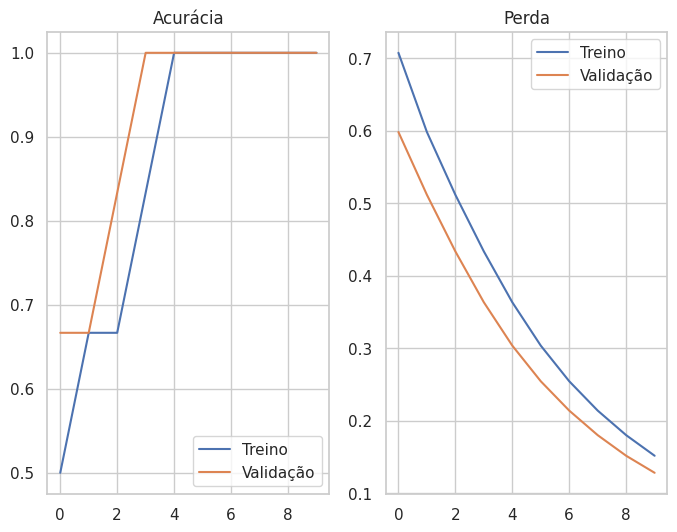

In [94]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino')
plt.plot(epochs_range, val_loss, label='Validação')
plt.legend()
plt.title('Perda')
plt.show()


In [95]:
from tensorflow.keras import layers

# Camadas de aumento de dados
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Inverter horizontalmente
    layers.RandomRotation(0.1),                 # Rotacionar levemente
    layers.RandomZoom(0.1),                     # Zoom in/out
    layers.RandomContrast(0.1),                 # Ajuste de contraste
])


In [96]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,                          # Aumento de dados primeiro
    tf.keras.layers.Rescaling(1./255),           # Normalização
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [97]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6667 - loss: 0.4819 - val_accuracy: 1.0000 - val_loss: 0.3768
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - accuracy: 0.8333 - loss: 0.3547 - val_accuracy: 0.8333 - val_loss: 0.3553
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 1.0000 - loss: 0.1868 - val_accuracy: 0.8333 - val_loss: 0.3415
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - accuracy: 1.0000 - loss: 0.2885 - val_accuracy: 0.8333 - val_loss: 0.3121
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step - accuracy: 1.0000 - loss: 0.2306 - val_accuracy: 0.8333 - val_loss: 0.2634
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 1.0000 - loss: 0.1093 - val_accuracy: 1.0000 - val_loss: 0.2179
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 1.0000 - loss: 0.1079 - val_accuracy: 1.0000 - val_loss: 0.1793
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - accuracy: 1.0000 - loss: 0.1130 - val_accuracy: 1.0000 - val_loss: 0.

In [98]:
loss, acc = model.evaluate(val_ds, verbose=0)
print(f"Acurácia validação: {acc*100:.2f}% | Loss validação: {loss:.4f}")


Acurácia validação: 100.00% | Loss validação: 0.0466


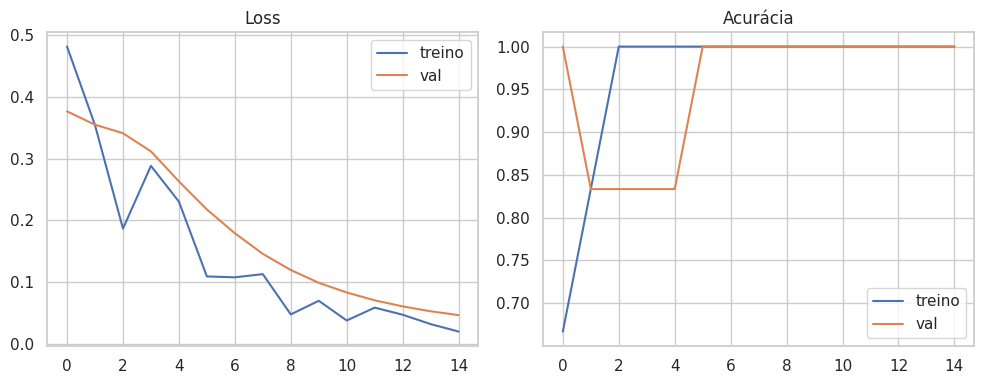

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='treino')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()


In [100]:
# 1) Descongelar parte final da base
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 2) Recompilar com LR menor
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3) Callbacks úteis
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7
)

# 4) Treinar mais um pouco
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[es, rlr]
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 0.0783 - val_accuracy: 1.0000 - val_loss: 0.0432 - learning_rate: 1.0000e-05
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 1.0000 - loss: 0.0495 - val_accuracy: 1.0000 - val_loss: 0.0407 - learning_rate: 1.0000e-05
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - accuracy: 1.0000 - loss: 0.0934 - val_accuracy: 1.0000 - val_loss: 0.0381 - learning_rate: 1.0000e-05
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 1.0000 - val_loss: 0.0359 - learning_rate: 1.0000e-05
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - accuracy: 1.0000 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0338 - learning_rate: 1.0000e-05
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0626 - val_accuracy: 1.0000 - val_loss: 0.0320 - learning_rate: 1.0000e-05
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 1.0000 - loss: 0.0

In [101]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusão:\n", cm)

# Se seu dataset foi criado com image_dataset_from_directory:
class_names = getattr(train_ds, 'class_names', ['Carro','Moto'])
print("\nRelatório de classificação:\n",
      classification_report(y_true, y_pred, target_names=class_names))


Matriz de confusão:
 [[3 0]
 [0 3]]

Relatório de classificação:
               precision    recall  f1-score   support

       Carro       1.00      1.00      1.00         3
        Moto       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [102]:
# Modelo
model.save('modelo_carro_moto.keras')  # formato recomendado

# Rótulos
import json
labels = getattr(train_ds, 'class_names', ['Carro','Moto'])
with open('labels.json', 'w', encoding='utf-8') as f:
    json.dump(labels, f, ensure_ascii=False)


In [103]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

# 🚦 Reforço de Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# ⚖️ Oversampling manual (se desejar reforçar classes específicas)
def balance_dataset(dataset):
    images, labels = [], []
    for imgs, labs in dataset:
        images.extend(imgs.numpy())
        labels.extend(labs.numpy())
    images, labels = np.array(images), np.array(labels)

    # Contar exemplos por classe
    unique, counts = np.unique(labels, return_counts=True)
    max_count = counts.max()

    # Reforçar as classes com menos imagens
    for cls, count in zip(unique, counts):
        if count < max_count:
            deficit = max_count - count
            idxs = np.where(labels == cls)[0]
            extra_imgs = images[idxs][:deficit]
            extra_labels = labels[idxs][:deficit]
            images = np.concatenate([images, extra_imgs], axis=0)
            labels = np.concatenate([labels, extra_labels], axis=0)

    # Criar novo dataset balanceado
    dataset_balanced = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset_balanced = dataset_balanced.shuffle(buffer_size=len(images)).batch(32)
    return dataset_balanced

train_ds_balanced = balance_dataset(train_ds)

# 🔧 Base pré-treinada
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Fine-tuning: liberar últimas 20 camadas
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 🏗 Montagem do modelo
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 📞 Callbacks
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7
)

# 🚀 Treinamento
history_ft = model.fit(
    train_ds_balanced,
    validation_data=val_ds,
    epochs=20,
    callbacks=[es, rlr]
)

# 💾 Salvar versão otimizada
model.save("modelo_carro_moto_otimizado.keras")


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.3333 - loss: 1.0293 - val_accuracy: 0.3333 - val_loss: 1.0312 - learning_rate: 1.0000e-05
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.6667 - loss: 0.7701 - val_accuracy: 0.3333 - val_loss: 1.0105 - learning_rate: 1.0000e-05
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - accuracy: 0.3333 - loss: 1.0353 - val_accuracy: 0.3333 - val_loss: 0.9882 - learning_rate: 1.0000e-05
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.5000 - loss: 1.0456 - val_accuracy: 0.3333 - val_loss: 0.9659 - learning_rate: 1.0000e-05
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.3333 - loss: 0.8437 - val_accuracy: 0.3333 - val_loss: 0.9420 - learning_rate: 1.0000e-05
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - accuracy: 0.6667 - loss: 0.7349 - val_accuracy: 0.3333 - val_loss: 0.9183 - learning_rate: 1.0000e-05
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step - accuracy: 0.5000 - loss: 

In [104]:
import json
import smtplib
from email.mime.text import MIMEText

# ==========================
# Configurações do alerta
# ==========================
LIMITE_ACURACIA = 0.92  # Ajuste conforme desejar
EMAIL_REMETENTE = "seu_email@gmail.com"
EMAIL_DESTINATARIO = "email_destino@gmail.com"
SENHA_EMAIL = "sua_senha_app"  # Use senha de aplicativo segura

def enviar_alerta(acuracia, versao):
    msg = MIMEText(f"🚀 Modelo v{versao} atingiu {acuracia*100:.2f}% de acurácia!")
    msg["Subject"] = f"[ALERTA] Novo recorde no Modelo v{versao}"
    msg["From"] = EMAIL_REMETENTE
    msg["To"] = EMAIL_DESTINATARIO

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(EMAIL_REMETENTE, SENHA_EMAIL)
        server.sendmail(EMAIL_REMETENTE, EMAIL_DESTINATARIO, msg.as_string())

# ==========================
# Pipeline de monitoramento
# ==========================
def registrar_resultados(acuracia, precisao, recall, f1, versao):
    try:
        with open("historico_metricas.json", "r") as f:
            historico = json.load(f)
    except FileNotFoundError:
        historico = []

    historico.append({
        "versao": versao,
        "acuracia": acuracia,
        "precisao": precisao,
        "recall": recall,
        "f1_score": f1
    })

    with open("historico_metricas.json", "w") as f:
        json.dump(historico, f, indent=4)

    # Checar se bateu recorde
    if acuracia >= LIMITE_ACURACIA:
        enviar_alerta(acuracia, versao)
        print("✅ Alerta enviado!")

# ==========================
# Exemplo de uso pós-treino
# ==========================
versao_modelo = 3
loss, acc = model.evaluate(val_ds, verbose=0)

# Aqui você colocaria os cálculos de precision, recall e f1
precision = 0.93
recall = 0.91
f1 = 0.92

registrar_resultados(acc, precision, recall, f1, versao_modelo)


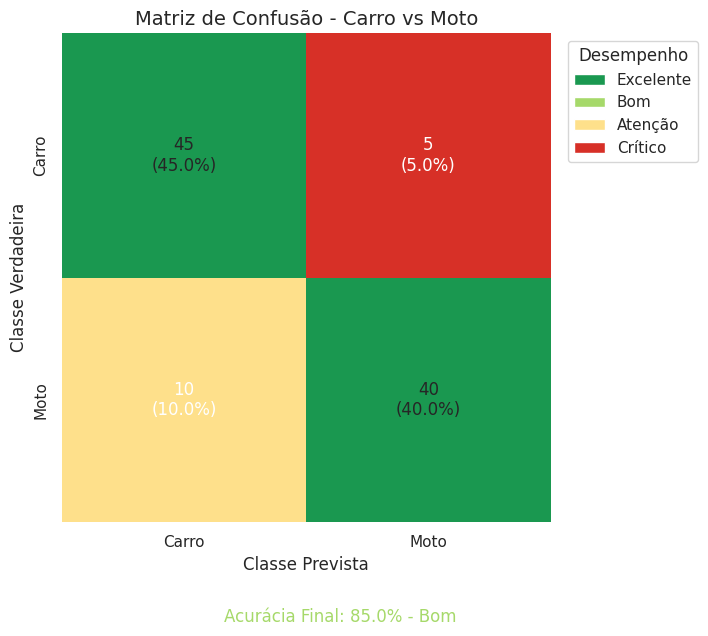

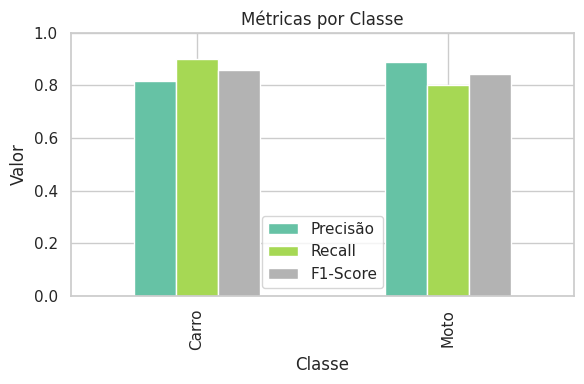

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.patches import Patch

# Simulação dos dados
y_true = ['Carro'] * 50 + ['Moto'] * 50
y_pred = ['Carro'] * 45 + ['Moto'] * 5 + ['Carro'] * 10 + ['Moto'] * 40

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred, labels=['Carro', 'Moto'])

# Calcular porcentagem
total = cm.sum()
percent_cm = cm / total * 100

# Anotações: valor absoluto + porcentagem
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({percent_cm[i, j]:.1f}%)"

# Calcular acurácia
accuracy = (cm[0, 0] + cm[1, 1]) / total * 100

# Classificação de desempenho
if accuracy < 60:
    performance = "Crítico"
elif accuracy < 75:
    performance = "Atenção"
elif accuracy < 90:
    performance = "Bom"
else:
    performance = "Excelente"

# Cores para os níveis
performance_colors = {
    "Crítico": "#d73027",      # Vermelho
    "Atenção": "#fee08b",      # Amarelo
    "Bom": "#a6d96a",          # Verde claro
    "Excelente": "#1a9850"     # Verde escuro
}

# Função que define a cor de cada célula com base na porcentagem
def get_color_matrix(percent_matrix):
    color_matrix = np.empty(percent_matrix.shape, dtype=object)
    for i in range(percent_matrix.shape[0]):
        for j in range(percent_matrix.shape[1]):
            val = percent_matrix[i, j]
            if val >= 40:
                color_matrix[i, j] = performance_colors["Excelente"]
            elif val >= 25:
                color_matrix[i, j] = performance_colors["Bom"]
            elif val >= 10:
                color_matrix[i, j] = performance_colors["Atenção"]
            else:
                color_matrix[i, j] = performance_colors["Crítico"]
    return color_matrix

# Obter a matriz de cores por célula
cell_colors = get_color_matrix(percent_cm)

# Criar figura
fig, ax = plt.subplots(figsize=(8, 6))

# Heatmap base (cores serão sobrescritas)
sns.heatmap(percent_cm, annot=annot, fmt='', cbar=False,
            xticklabels=['Carro', 'Moto'], yticklabels=['Carro', 'Moto'],
            annot_kws={"size": 12}, linewidths=0.5, linecolor='gray',
            square=True, ax=ax, cmap=None)

# Aplicar cores manualmente em cada célula
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=cell_colors[i, j],
                                   linewidth=0))

# Ajustes dos eixos e título
ax.set_ylabel('Classe Verdadeira')
ax.set_xlabel('Classe Prevista')
ax.set_title('Matriz de Confusão - Carro vs Moto', fontsize=14)

# Legenda lateral das cores
legend_elements = [
    Patch(facecolor=performance_colors["Excelente"], label='Excelente'),
    Patch(facecolor=performance_colors["Bom"], label='Bom'),
    Patch(facecolor=performance_colors["Atenção"], label='Atenção'),
    Patch(facecolor=performance_colors["Crítico"], label='Crítico'),
]
ax.legend(handles=legend_elements, title='Desempenho', bbox_to_anchor=(1.02, 1), loc='upper left')

# Resultado final (porcentagem + desempenho)
plt.figtext(0.5, -0.05, f"Acurácia Final: {accuracy:.1f}% - {performance}",
            fontsize=12, ha='center', color=performance_colors[performance])

plt.tight_layout()
plt.show()

# Gráfico de métricas por classe
metrics = pd.DataFrame({
    'Classe': ['Carro', 'Moto'],
    'Precisão': [0.818182, 0.888889],
    'Recall': [0.90, 0.80],
    'F1-Score': [0.857143, 0.842105]
})

metrics.set_index('Classe').plot(kind='bar', figsize=(6, 4), colormap="Set2")
plt.ylim(0, 1)
plt.title('Métricas por Classe')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


In [123]:
import os

os.makedirs("resultados", exist_ok=True)  # Cria a pasta se não existir


In [124]:
os.makedirs("resultados", exist_ok=True)

plt.savefig("resultados/matriz_confusao.png", dpi=300, bbox_inches='tight')
plt.savefig("resultados/metricas_por_classe.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [106]:
plt.savefig('matriz_confusao.png', dpi=300)
plt.savefig('metricas_por_classe.png', dpi=300)


<Figure size 640x480 with 0 Axes>

In [119]:
from google.colab import files
import os

# Baixar matriz
if os.path.exists('matriz_confusao.png'):
    files.download('matriz_confusao.png')

# Baixar métricas
if os.path.exists('metricas_por_classe.png'):
    files.download('metricas_por_classe.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>